# Explorative data analysis of real world data on multiple sclerosis

This script extends the first script of that analysed the dataset. In this script here, I will train a model to address the following research questions:

- Based on the test results, can I classify subjects into diagnosed and control group?
- Which of the used methods is best suited for this classification problem?
- Which metric is most important to predict the participant group?
---

## 3) Modelling

Importing required libraries:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
from datetime import date
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
import math

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from treeinterpreter import treeinterpreter as ti

#from sklearn.metrics import confusion_matrix, roc_curve, 
sns.set_palette("RdBu_r", 7) # this sets the color palette
import warnings
from warnings import filterwarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')#, category=DataConversionWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None) # display all columns

In [2]:
%store -r df # get dataframe from EDA script
df_model = df

Dropping unnecessary and Timestamp columns:

In [5]:
df_model = df_model.drop(columns=['floodlightOpenId','participantCreatedOn','testCode','testMetricCode','participantIsControl','testStartedAt','testEndedAt','testResultMetricCreatedOn','Delta_test_register'])

Defining the features and dependent variable:

In [6]:
X = df_model
X.head()

,participantCountryOfResidence,participantSex,participantBirthYear,participantWeightLbs,participantHeightCms,testName,testMetricName,testResultMetricId,testResultMetricValue,Weekday_testResultCreatedOn,Holiday_testResultCreatedOn,Delta_Weeks_test_register,Delta_Dayss_test_register
0,US,male,1966,159.0,178.0,Daily Questions,Mood Response,115524,4.00,1,False,0,1
1,US,male,1966,159.0,178.0,Daily Questions,Mood Response,116040,5.00,3,False,0,3
4,US,male,1966,159.0,178.0,IPS,Correct Responses,116043,39.00,3,False,0,3
5,US,male,1966,159.0,178.0,IPS,Response Time Average,116044,2.31,3,False,0,3
6,US,male,1966,159.0,178.0,Pinching,Successful Pinches,116045,27.00,3,False,0,3


In [25]:
y = df['participantIsControl']
y = y.reindex_like(X)

One hot encoding categorial variables:

In [8]:
# create dummy variables of
dummy = pd.get_dummies(X['participantCountryOfResidence'],prefix='Country', columns = ['participantCountryOfResidence'], drop_first=True)
dummy2 = pd.get_dummies(X['participantSex'],prefix='Sex', columns = ['participantSex'], drop_first=True)
dummy3 = pd.get_dummies(X['testName'],prefix='testName', columns = ['testName'], drop_first=True)
dummy4 = pd.get_dummies(X['testMetricName'],prefix='testMetric', columns = ['testMetricName'], drop_first=True)
dummy5 = pd.get_dummies(X['Weekday_testResultCreatedOn'],prefix='Weekday', columns = ['Weekday_testResultCreatedOn'], drop_first=True)
dummy6 = pd.get_dummies(X['Holiday_testResultCreatedOn'],prefix='Holiday', columns = ['Holiday_testResultCreatedOn'], drop_first=True)
X = pd.concat([dummy,dummy2,dummy3,dummy4,dummy5,dummy6,X], axis=1);
X = X.drop(columns=['participantCountryOfResidence','participantSex','testResultMetricId','testName','testMetricName','Weekday_testResultCreatedOn','Holiday_testResultCreatedOn'], axis=1);
# reset indexes
X.reset_index(inplace=True)
X_index = X['index']
X = X.drop(columns=['index'], axis=1);
X.head()

,Country_BE,Country_BR,Country_CA,Country_CH,Country_CZ,Country_DK,Country_ES,Country_FI,Country_IT,Country_PL,Country_US,Sex_male,testName_Draw A Shape,testName_Five UTurn Test,testName_IPS,testName_Mobility,testName_Pinching,testName_Static Balance,testName_Two Minute Walk Test,testMetric_Circle Hausdorff Distance Best,testMetric_Correct Responses,testMetric_Figure 8 Hausdorff Distance Best,testMetric_Hand Used,testMetric_Life Space Daily,testMetric_Mean Hausdorff Distance Best,testMetric_Mood Response,testMetric_Number of shapes drawn correctly,testMetric_Response Time Average,testMetric_Spiral Hausdorff Distance Best,testMetric_Square Hausdorff Distance Best,testMetric_Steps,testMetric_Successful Pinches,testMetric_Sway Path,testMetric_Top to bottom Hausdorff Distance Best,testMetric_Turn Speed Average,testMetric_Turns,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Weekday_7,Holiday_True,participantBirthYear,participantWeightLbs,participantHeightCms,testResultMetricValue,Delta_Weeks_test_register,Delta_Dayss_test_register
0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1966,159.0,178.0,4.00,0,1
1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1966,159.0,178.0,5.00,0,3
2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1966,159.0,178.0,39.00,0,3
3,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1966,159.0,178.0,2.31,0,3
4,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1966,159.0,178.0,27.00,0,3


In [9]:
y.reset_index(drop=True,inplace = True)
#y = y*1
y.head()

0    True
1    True
2    True
3    True
4    True
Name: participantIsControl, dtype: bool

In [10]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

Splitting the dataset into the Training set and Test set:

In [11]:
# using Stratified K-Folds cross-validator for train set
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=123)

# without cross-validation
#X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size = 0.25)
#X_rest.reset_index(drop=True,inplace = True)
#y_rest.reset_index(drop=True,inplace = True)

Feature Scaling:

In [21]:
#sc = StandardScaler()
#X_train = sc.fit_transform(X_rest)
#X_test = sc.transform(X_test)

## Logistic regression: 

In [43]:
classifier_LR = LogisticRegression(solver = 'saga')
# classifier_LR.fit(X_train, y_train) # no crossvalidation

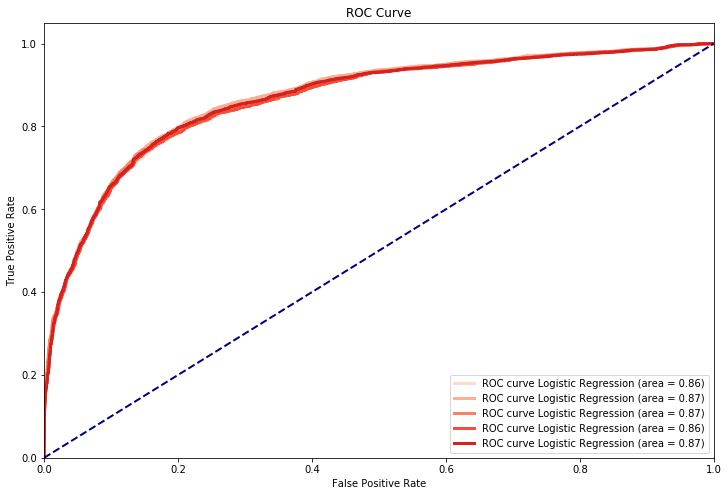

In [44]:
# Run classifier with cross-validation and plot individual ROC curves
sns.set_palette("Reds")

fig, ax = plt.subplots(figsize=(12,8))
for i, (train, test) in enumerate(cv.split(X, y)):
    sc = StandardScaler()
    X_train_cv = sc.fit_transform(X.loc[train])
    X_test_cv = sc.transform(X.loc[test])
    classifier_LR.fit(X_train_cv, y[train])
    fpr_cv, tpr_cv, _ = roc_curve(y[test], classifier_LR.predict_proba(X_test_cv)[:,1])    
    roc_auc_cv = auc(fpr_cv, tpr_cv)
    plt.plot(fpr_cv, tpr_cv, lw=3, label='ROC curve Logistic Regression (area = %0.2f)' % roc_auc_cv)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#y_pred_LR = classifier_LR.predict(X_test)

In [ ]:
#cm_LR = confusion_matrix(y_test, y_pred_LR)
#cm_LR

Calculate the average AUC (Area Under Curve) value:

In [ ]:
#fpra_LR, tpra_LR, _ = roc_curve(y_test, y_pred_LR)
#auc_LR = auc(fpra_LR, tpra_LR)
#print('AUC Logistic Regression:',auc_LR)

In [ ]:
'''y_pred_LR_train = classifier_LR.predict(X_train)*1
y_train = y_train*1
mse_LR_train = metrics.mean_squared_error(y_train.values,y_pred_LR_train)
R2_LR_train = classifier_LR.score(X_train,y_train)
print('Logistic Regression - Train Set')
print('RMSE:',math.sqrt(mse_LR_train),'   R2:',R2_LR_train)'''

In [ ]:
'''y_pred_LR = y_pred_LR*1
y_test = y_test*1
mse_LR_test = metrics.mean_squared_error(y_test.values,y_pred_LR)
R2_LR_test = classifier_LR.score(X_test,y_test)
print('Logistic Regression - Test Set')
print('RMSE:',math.sqrt(mse_LR_test),'   R2:',R2_LR_test)'''

I plot the ROC curve to evaluate the effectiveness of the approach: the true positive rate (sensitivity) is plotted over the false positive rate (100-specificity).

In [ ]:
'''fpr_LR, tpr_LR, _ = roc_curve(y_test, classifier_LR.predict_proba(X_test)[:,1])
roc_auc_LR = auc(fpr_LR, tpr_LR)
# plot
plt.figure()
plt.plot(fpr_LR, tpr_LR, color='darkorange',
         lw=2, label='ROC curve Logistic Regression (area = %0.2f)' % roc_auc_LR)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()'''

## k-NN:

The k Nearest Neighbors approach requires timely computations to predict the test data set, which often is critical e.g. for online classification.  

In [ ]:
'''classifier_kNN = KNeighborsClassifier(n_neighbors = 15, metric = 'minkowski', p = 2)
classifier_kNN.fit(X_train, y_train)
y_pred_kNN = classifier_kNN.predict(X_test)
cm_kNN = confusion_matrix(y_test, y_pred_kNN)
cm_kNN
y_pred_kNN_train = classifier_kNN.predict(X_train)*1
y_train = y_train*1
mse = metrics.mean_squared_error(y_train.values,y_pred_kNN_train)
print('k-NN - Train Set')
print('RMSE:',math.sqrt(mse),'   R2:',classifier_kNN.score(X_train,y_train))
y_pred_kNN = y_pred_kNN*1
y_test = y_test*1
mse = metrics.mean_squared_error(y_test.values,y_pred_kNN)
print('k-NN - Test Set')
print('RMSE:',math.sqrt(mse),'   R2:',classifier_kNN.score(X_test,y_test))'''

## Support Vector Machines:

In this example, the support vector classifier requires exhaustive computations to train the model. I will therefore ignore this approach.

In [ ]:
'''# single SVM: 
classifier_SVM = SVC(kernel = 'linear', class_weight ='balanced')
# Ensemble approach: 
n_estimators = 10
classifier_SVM = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), bootstrap=False, max_samples=1.0 / n_estimators, n_estimators=n_estimators))
classifier_SVM.fit(X_train, y_train)
y_pred_SVM = classifier_SVM.predict(X_test)
cm_SVM = confusion_matrix(y_test, y_pred_SVM)
cm_SVM'''

## Naive Bayes:

In [39]:
classifier_NB = GaussianNB()
#classifier_NB.fit(X_train, y_train) # no crossvalidation

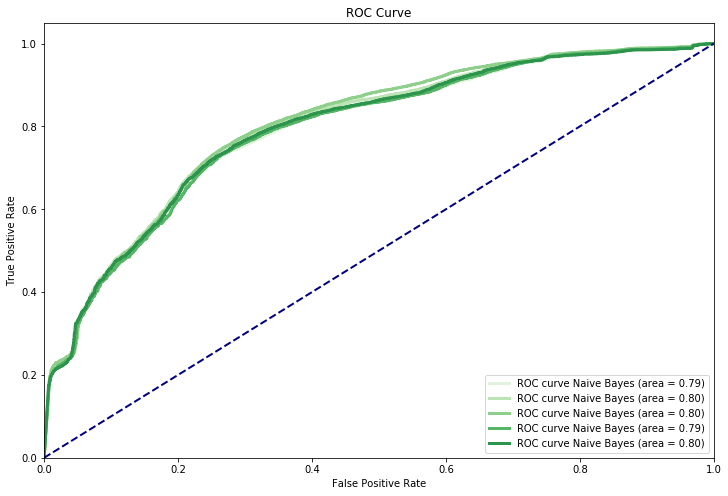

In [41]:
# Run classifier with cross-validation and plot individual ROC curves
sns.set_palette("Greens")

fig, ax = plt.subplots(figsize=(12,8))
for i, (train, test) in enumerate(cv.split(X, y)):
    sc = StandardScaler()
    X_train_cv = sc.fit_transform(X.loc[train])
    X_test_cv = sc.transform(X.loc[test])
    classifier_NB.fit(X_train_cv, y[train])
    fpr_cv, tpr_cv, _ = roc_curve(y[test], classifier_NB.predict_proba(X_test_cv)[:,1])    
    roc_auc_cv = auc(fpr_cv, tpr_cv)
    plt.plot(fpr_cv, tpr_cv, lw=3, label='ROC curve Naive Bayes (area = %0.2f)' % roc_auc_cv)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#y_pred_NB = classifier_NB.predict(X_test)

In [ ]:
#cm_NB = confusion_matrix(y_test, y_pred_NB)
#cm_NB

In [ ]:
#fpra_NB, tpra_NB, _ = roc_curve(y_test, y_pred_NB)
#auc_NB = auc(fpra_NB, tpra_NB)
#print('AUC Naive Bayes:',auc_NB)

In [ ]:
'''y_pred_NB_train = classifier_NB.predict(X_train)*1
y_train = y_train*1
mse_NB_train = metrics.mean_squared_error(y_train.values,y_pred_NB_train)
R2_NB_train = classifier_NB.score(X_train,y_train)
print('Naive Bayes - Train Set')
print('RMSE:',math.sqrt(mse_NB_train),'   R2:',R2_NB_train)'''

In [ ]:
'''y_pred_NB = y_pred_NB*1
y_test = y_test*1
mse_NB_test = metrics.mean_squared_error(y_test.values,y_pred_NB)
R2_NB_test = classifier_NB.score(X_test,y_test)
print('Naive Bayes - Test Set')
print('RMSE:',math.sqrt(mse_NB_test),'   R2:',R2_NB_test)'''

Both R2 are worse than for the logistic regression. Let's look at the ROC curve.

In [ ]:
'''fpr_NB, tpr_NB, _ = roc_curve(y_test, classifier_NB.predict_proba(X_test)[:,1])
roc_auc_NB = auc(fpr_NB, tpr_NB)
# plot
plt.figure()
plt.plot(fpr_LR, tpr_LR, color='darkorange',
         lw=2, label='ROC curve Logistic Regression (area = %0.2f)' % roc_auc_LR)
plt.plot(fpr_NB, tpr_NB, color='red',
         lw=2, label='ROC curve Naive Bayes (area = %0.2f)' % roc_auc_NB)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()'''

This shows that the logistic regression performed better in classifiying participants than the Naive Bayes approach.

## Random Forest:

In [16]:
classifier_RF = RandomForestClassifier(n_estimators = 25, max_depth = 10, criterion = 'entropy')
#classifier_RF.fit(X_train, y_train) # no crossvalidation

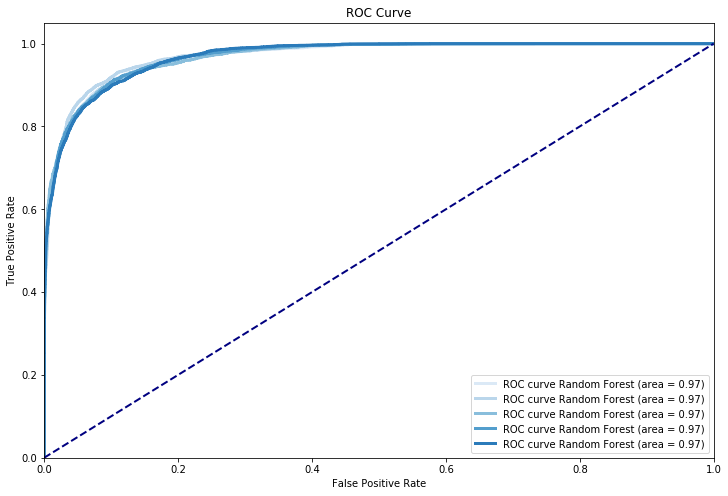

In [17]:
# Run classifier with cross-validation and plot individual ROC curves
sns.set_palette("Blues")

fig, ax = plt.subplots(figsize=(12,8))
for i, (train, test) in enumerate(cv.split(X, y)):
    X_train_cv = X.loc[train]
    X_train_cv.reset_index(drop = True, inplace=True) # reset indexes
    y_train_cv = y[train]
    X_test_cv = X.loc[test]
    X_test_cv.reset_index(drop = True, inplace=True) # reset indexes
    y_test_cv = y[test]
    # feature scaling
    sc = StandardScaler()
    X_train_cv = sc.fit_transform(X_train_cv)
    X_test_cv = sc.transform(X_test_cv)
    
    classifier_RF.fit(X_train_cv, y_train_cv)
    fpr_cv, tpr_cv, _ = roc_curve(y_test_cv, classifier_RF.predict_proba(X_test_cv)[:,1])    
    roc_auc_cv = auc(fpr_cv, tpr_cv)
    plt.plot(fpr_cv, tpr_cv, lw=3, label='ROC curve Random Forest (area = %0.2f)' % roc_auc_cv)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#y_pred_RF = classifier_RF.predict(X_test)

In [ ]:
#cm_RF = confusion_matrix(y_test, y_pred_RF)
#cm_RF

In [ ]:
'''fpra_RF, tpra_RF, _ = roc_curve(y_test, y_pred_RF)
auc_RF = auc(fpra_RF, tpra_RF)
print('AUC Random Forest:',auc_RF)'''

In [ ]:
'''y_pred_RF_train = classifier_RF.predict(X_train)*1
y_train = y_train*1
mse_RF_train = metrics.mean_squared_error(y_train.values,y_pred_RF_train)
R2_RF_train = classifier_RF.score(X_train,y_train)
print('Random Forest - Train Set')
print('RMSE:',math.sqrt(mse_RF_train),'   R2:',R2_RF_train)'''

In [ ]:
'''y_pred_RF = y_pred_RF*1
y_test = y_test*1
mse_RF_test = metrics.mean_squared_error(y_test.values,y_pred_RF)
R2_RF_test = classifier_RF.score(X_test,y_test)
print('Random Forest - Test Set')
print('RMSE:',math.sqrt(mse_RF_test),'   R2:',R2_RF_test)'''

The model did well to classify the participants. We can also see that the model didn't overfit (since R2 of the test set is pretty close to the R2 of the train set).  
Since the Random Forest is a tree-based approach, we do not get probabilities of the classifications. Subsequently, we can not plot the ROC curve for this model. However, the R2 seems pretty convincing.

In [ ]:
'''fpr_RF, tpr_RF, _ = roc_curve(y_test, classifier_RF.predict_proba(X_test)[:,1])
roc_auc_RF = auc(fpr_RF, tpr_RF)
# plot
plt.figure()
plt.plot(fpr_LR, tpr_LR, color='darkorange',
         lw=2, label='ROC curve Logistic Regression (area = %0.2f)' % roc_auc_LR)
plt.plot(fpr_NB, tpr_NB, color='red',
         lw=2, label='ROC curve Naive Bayes (area = %0.2f)' % roc_auc_NB)
plt.plot(fpr_RF, tpr_RF, color='blue',
         lw=2, label='ROC curve Random Forest (area = %0.2f)' % roc_auc_RF)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()'''

---
Now this is the **overview of all models**:

In [ ]:
print("Model                 " + "R2 Test   " + "R2 Train" )
print("Logistic Regression   " + "%2.4f    %2.4f" % (R2_LR_train,R2_LR_test))
print("Naive Bayes           " + "%2.4f    %2.4f" % (R2_NB_train,R2_NB_test))
print("Random Forest         " + "%2.4f    %2.4f" % (R2_RF_train,R2_RF_test))

## 4) Test Hyperparameters

**Grid search to check hyperparameters for best model (Random Forest)**

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [21]:
# Set the parameters by cross-validation
tuned_parameters = [{'n_estimators': [10, 25], 'max_depth': [5, 10, 20]}]
scores = ['precision', 'recall']

In [22]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        RandomForestClassifier(n_estimators=25, criterion = 'entropy'), tuned_parameters, scoring='%s_macro' % score
    )
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'max_depth': 20, 'n_estimators': 25}

Grid scores on development set:

0.858 (+/-0.017) for {'max_depth': 5, 'n_estimators': 10}
0.881 (+/-0.011) for {'max_depth': 5, 'n_estimators': 25}
0.924 (+/-0.003) for {'max_depth': 10, 'n_estimators': 10}
0.923 (+/-0.005) for {'max_depth': 10, 'n_estimators': 25}
0.981 (+/-0.005) for {'max_depth': 20, 'n_estimators': 10}
0.987 (+/-0.002) for {'max_depth': 20, 'n_estimators': 25}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     39273
           1       0.99      0.96      0.97     10922

   micro avg       0.99      0.99      0.99     50195
   macro avg       0.99      0.98      0.98     50195
weighted avg       0.99      0.99      0.99     50195


# Tuning hyper-paramete

Our previously used settings ('n_estimators=25') seems like a reasonable setting.

## 5) Model interpretation

**Feature importance**

Let's look at the importance of each feature and plot the 10 most important features:

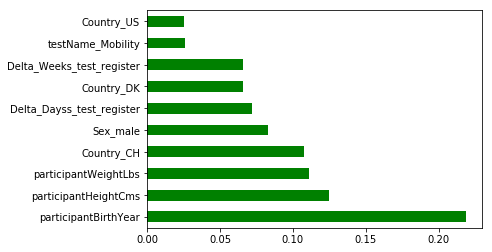

In [24]:
feat_importances = pd.Series(classifier_RF.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh',color='green')
plt.show()

We can see that the most important features came from anthropomorphic data (like age, sex, height and weight) and the test results.

This is an imbalanced classification problem, so accuracy is not an appropriate metric.